In [2]:
source("./libs.R")

## data load

In [3]:
##------------------------------------------------------------
## inputs
##------------------------------------------------------------

input.chromVar.res.list <- readRDS(file = "../dat/output.jaspar.dev.res.Rdata")
input.chromVar.jaspar.z <- assays(input.chromVar.res.list$dev)$z
input.umap.res <- fread('../dat/1908/Islet_123.MNN_corrected.cluster_labels.filt.txt',header = T)
input.chromVar.jaspar.var <- fread("../dat/1908/output.jaspar.var.res.abcd.csv")

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 600 rows [5, 18, 19, 50, 81, 114, 128, 147, 169, 175, 176, 190, 209, 250, 260, 345, 353, 376, 389, 413, ...].”

barcodes,UMAP1,UMAP2,cluster,cell_type_overall,subtype,log10_n_counts,log10_n_peaks,Islet1,Islet2,Islet3
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>
Islet3-fresh_CTGAAGCTTGCAGCTACTCTCTATTATAGCCT,6.029433,-3.429818,beta_2,beta,2,4.520863,4.152013,0,0,1


[1] 14239    11

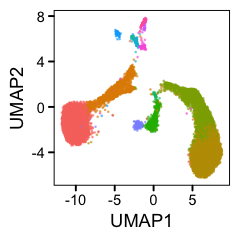

In [4]:
options(repr.plot.width = 2, repr.plot.height = 2)
# filter unkonwn
input.umap.res <- input.umap.res %>% separate(cluster, into = c("cell_type_overall", 
    "subtype"), remove = F)
head(input.umap.res, 1)
dim(input.umap.res)
ggplot(input.umap.res, aes(UMAP1, UMAP2)) + geom_point(aes(color = cluster), size = 0.1, 
    alpha = 0.5) + theme_pubr() + theme(legend.position = "none")

In [5]:
input.chromVar.jaspar.z <- assays(input.chromVar.res.list$dev)$z

table(input.umap.res %>% filter(barcodes %in% colnames(input.chromVar.jaspar.z)[-1]) %>% 
    pull(cell_type_overall))
table(input.umap.res %>% pull(cell_type_overall))


      alpha        beta       delta endothelial    exocrine       gamma 
       5535        7108         709         136         113         205 
      glial      immune    stellate 
         34          58         134 


      alpha        beta       delta endothelial    exocrine       gamma 
       5594        7170         718         157         131         206 
      glial      immune    stellate 
         39          71         153 

In [6]:
input.chromVar.jaspar.z.agg <- melt(data.table(assays(input.chromVar.res.list$dev)$z, 
    keep.rownames = T), id = "rn", variable.name = "barcodes", value.name = "zval")
input.chromVar.jaspar.z.agg %>% head(1)

input.chromVar.jaspar.z.agg %>% nrow
input.chromVar.jaspar.z.agg <- input.chromVar.jaspar.z.agg %>% inner_join(input.umap.res) %>% 
    separate(rn, into = c("id", "name"), sep = "_")
input.chromVar.jaspar.z.agg %>% nrow

input.chromVar.jaspar.z.agg %>% head(1)
input.chromVar.jaspar.z.agg %>% select(barcodes, cell_type_overall) %>% unique %>% 
    pull(cell_type_overall) %>% table

range(input.chromVar.jaspar.z.agg$zval)

rn,barcodes,zval
<chr>,<fct>,<dbl>
MA0025.1_NFIL3,Islet1-fresh_AGACACCTAAGAGGCAAAGGAGTACCTAT,-0.3430543


[1] 5692728

Joining, by = "barcodes"
Warning message:
“Column `barcodes` joining factor and character vector, coercing into character vector”

[1] 5416738

id,name,barcodes,zval,UMAP1,UMAP2,cluster,cell_type_overall,subtype,log10_n_counts,log10_n_peaks,Islet1,Islet2,Islet3
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>
MA0025.1,NFIL3,Islet1-fresh_AGACACCTAAGAGGCAAAGGAGTACCTAT,-0.3430543,6.975175,-3.232226,beta_1,beta,1,3.694693,3.384174,1,0,0


.
      alpha        beta       delta endothelial    exocrine       gamma 
       5535        7109         709         136         113         205 
      glial      immune    stellate 
         34          58         134 

[1] -17.90770  35.45968

In [7]:
ttest.res<- fread("~/Dropbox (UCSD_Epigenomics)/workReports/2019-10_islet_rev/fig1S_one_vs_one.csv") 
ttest.res%>%head(1)
dim(ttest.res)
ttest.res%>%select(motif,test)%>%unique%>%nrow

rank,motif,mean_x,mean_y,pval,test,x,y,enrichedIn,FDR,padj,diff,id,family.id,family.name,class.id,class.name,superclass.id,superclass.name
<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>,<chr>
1,MAFG,0.4259281,-2.01688,1.42e-74,alpha_vs_gamma,alpha,gamma,alpha,5.4812e-72,5.4812e-72,2.442808,MA0659.1,1.1.3,Maf-related,1.1,Basic leucine zipper factors (bZIP),1,Basic domains


[1] 790  19

[1] 772

## functions

In [8]:
fun.plot.project.motif <- function(motif, input.chromVar.z = input.chromVar.jaspar.z, 
    umap.res = input.umap.res, rescale = F, cls, bks = c(-4, 0, 4), ...) {
    require(scales)
    
    motif.idx <- grep(motif, rownames(input.chromVar.z))
    if (length(motif.idx) == 0) {
        message(motif, " is not found!")
        return()
    }
    
    motif.z <- input.chromVar.z[motif.idx[1], ]
    if (rescale) {
        sc <- max(abs(quantile(motif.z, probs = c(0.05, 0.95))))
        motif.z[motif.z > sc] <- sc
        motif.z[motif.z < -sc] <- -sc
    }
    
    motif.z <- motif.z %>% as.data.frame() %>% rownames_to_column("barcodes")
    colnames(motif.z)[2] <- "zval"
    
    tmp <- umap.res %>% right_join(motif.z)
    tmp <- tmp %>% mutate(zval = ifelse(zval > bks[3], bks[3], ifelse(zval < bks[1], 
        bks[1], zval)))
    p.default.cluster.motif <- ggplot(tmp, aes(UMAP1, UMAP2)) + geom_point(aes(colour = zval), 
        shape = 16, ...) + ggtitle(rownames(input.chromVar.jaspar.z)[motif.idx]) + 
        scale_color_gradientn(colours = cls, breaks = bks) + theme_pubr() + theme(text = element_blank(), 
        axis.ticks = element_blank(), legend.position = c(0.2, 0.9), legend.direction = "horizontal", 
        legend.key.width = unit(2, "mm"), legend.key.height = unit(0.1, "inches"), 
        legend.text = element_text(size = 10, family = "Arial"), legend.background = element_rect(fill = "transparent", 
            colour = "transparent"), plot.margin = unit(c(1, 1, -1, -1), "mm"))
    
    p.default.cluster.motif
}

Joining, by = "barcodes"
Joining, by = "barcodes"
Warning message:
“Removed 715 rows containing missing values (geom_point).”Warning message:
“Removed 715 rows containing missing values (geom_point).”

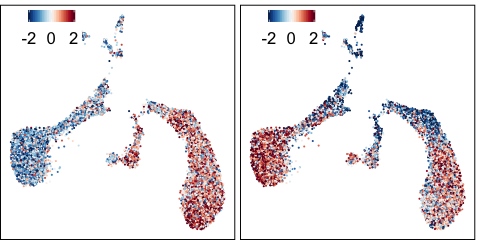

In [9]:
options(repr.plot.width = 4, repr.plot.height = 2)

ps <- lapply(c("PDX1", "FOXA1"), fun.plot.project.motif, bks = c(-2, 0, 
    2),size=.25,cls=rev(brewer.pal(n = 11, "RdBu")))
names(ps) <- c("PDX1", "FOXA1")
ggarrange(plotlist = ps, ncol = 2)

## beta vs delta

In [10]:
plotViolin <- function(motif = m, test_celltypes = celltype.test) {
    pd <- input.chromVar.jaspar.z.agg %>% filter(name == motif, cell_type_overall %in% 
        test_celltypes)
    pd$cell_type_overall <- factor(pd$cell_type_overall,levels = test_celltypes)
    ggviolin(pd, x = "cell_type_overall", remove = T, width = 0.5, y = "zval", size = 0.5, 
        shape = 16, draw_quantiles = c(0.25, 0.5, 0.75), fill = "cell_type_overall", 
        ylab = "Motif enrichment") + theme_pubr() + ggtitle(motif) + geom_hline(yintercept = 0, 
        linetype = 2, size = 0.25) + theme(legend.position = "none", axis.text.x = element_text(angle = 45, 
        hjust = 1), axis.title.x = element_blank()) + scale_fill_manual(values = cols.celltype)
    
}
options(repr.plot.width = 1.5, repr.plot.height = 2)
#plotViolin("SCRT1", c("beta", "delta"))

Joining, by = "barcodes"


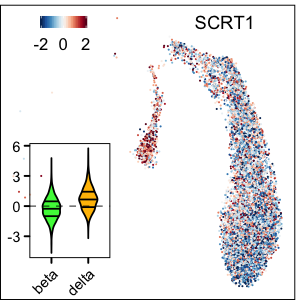

In [23]:
plotMotif_bd <- function(m = "TCF7L2") {
    options(repr.plot.width = 2.5, repr.plot.height = 2.5)
    
    p <- fun.plot.project.motif(motif = m, bks = c(-2, 0, 2), size = 0.25, cls = rev(brewer.pal(n = 11, 
        "RdBu")))
    p$data <- p$data %>% filter(cell_type_overall %in% c("beta", "delta"))
    p2 <- plotViolin(m, c("beta", "delta"))
    
    print(p + annotate(geom = "text", x = 5, y = 2.8, label = m) + annotation_custom((p2 + 
        theme(title = element_blank())) %>% ggplotGrob, -10.2, -2, -7, -1))
    
    ggsave(paste0("~/Dropbox (UCSD_Epigenomics)/workReports/2019-10_islet_rev/Fig1.rev.candid/Fig1.rev.candid.", 
        m, ".b_d.umap.pdf"), width = 2.5, height = 2.5, units = "in", useDingbats = F)
}
plotMotif_bd("SCRT1")


rank,motif,mean_x,mean_y,pval,test,x,y,enrichedIn,FDR,padj,diff,id
<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
187,NRL,-0.09615801,-1.187419,2.32e-89,beta_vs_delta,beta,delta,beta,8.9552e-87,8.9552e-87,1.091261,MA0842.1


[1]  2.00891 86.04792

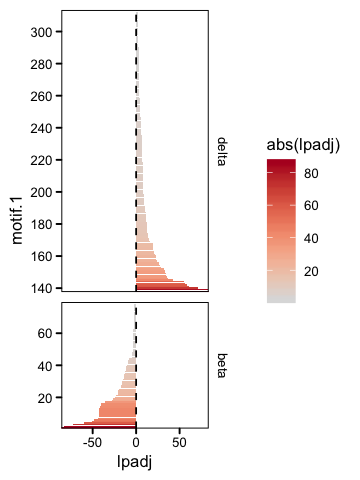

In [57]:
options(repr.plot.width = 3, repr.plot.height = 4)
require(pals)

pd.rank <- ttest.res %>% select(-contains(".")) %>% unique %>% filter(test == "beta_vs_delta") %>% 
    ungroup

head(pd.rank, 1)
n_m = nrow(pd.rank %>% filter(enrichedIn == "delta"))
n_m = 0
pd.rank <- pd.rank %>% mutate(motif.1 = as.numeric(factor(motif, levels = pd.rank$motif)) - 
    n_m, lpadj = ifelse(enrichedIn == "beta", log10(FDR), -log10(FDR))) %>% filter(FDR < 
    0.01) %>% mutate(enrichedIn = factor(enrichedIn, levels = c("delta", "beta")))
pd.rank%>%pull(lpadj)%>%abs%>%range
ggplot(pd.rank) + geom_bar(aes(motif.1, lpadj, fill = abs(lpadj)), stat = "identity") + 
    theme_pubr(base_size = 10) + theme() + coord_flip(expand = F) + scale_fill_gradientn(colours = pal.compress(coolwarm)[7:13]) + 
    scale_x_continuous(breaks = seq(0 - n_m, 386 - n_m, 20)) + facet_grid(enrichedIn ~ 
    ., scales = "free_y", space = "free_y") + geom_hline(yintercept = 0, linetype = 2)

rank,motif,mean_x,mean_y,pval,test,x,y,enrichedIn,FDR,padj,diff,id
<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,MAFG,0.4259281,-2.01688,1.42e-74,alpha_vs_gamma,alpha,gamma,alpha,5.4812e-72,5.4812e-72,2.442808,MA0659.1


[1]  2.064016 71.261124

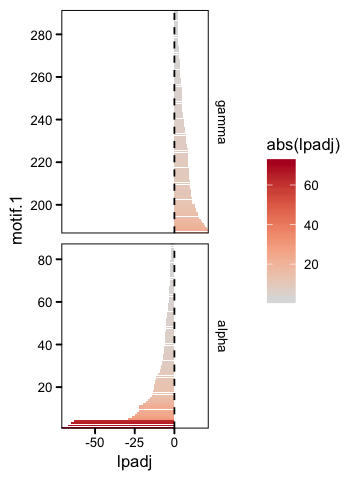

In [59]:
options(repr.plot.width = 3, repr.plot.height = 4)
require(pals)

pd.rank <- ttest.res %>% select(-contains(".")) %>% unique %>% filter(test == "alpha_vs_gamma") %>% 
    ungroup

head(pd.rank, 1)
n_m = nrow(pd.rank %>% filter(enrichedIn == "gamma"))
n_m = 0
pd.rank <- pd.rank %>% mutate(motif.1 = as.numeric(factor(motif, levels = pd.rank$motif)) - 
    n_m, lpadj = ifelse(enrichedIn == "alpha", log10(FDR), -log10(FDR))) %>% filter(FDR < 
    0.01) %>% mutate(enrichedIn = factor(enrichedIn, levels = c("gamma", "alpha")))
pd.rank%>%pull(lpadj)%>%abs%>%range
ggplot(pd.rank) + geom_bar(aes(motif.1, lpadj, fill = abs(lpadj)), stat = "identity") + 
    theme_pubr(base_size = 10) + theme() + coord_flip(expand = F) + scale_fill_gradientn(colours = pal.compress(coolwarm)[7:13]) + 
    scale_x_continuous(breaks = seq(0 - n_m, 386 - n_m, 20)) + facet_grid(enrichedIn ~ 
    ., scales = "free_y", space = "free_y") + geom_hline(yintercept = 0, linetype = 2)

Joining, by = "barcodes"


          UMAP1     UMAP2
[1,] -11.819448 -5.073896
[2,]   8.179459  6.196858


Joining, by = "barcodes"


          UMAP1     UMAP2
[1,] -11.819448 -5.073896
[2,]   8.179459  6.196858


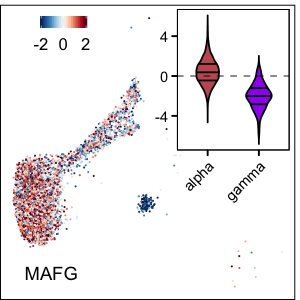

Joining, by = "barcodes"


          UMAP1     UMAP2
[1,] -11.819448 -5.073896
[2,]   8.179459  6.196858


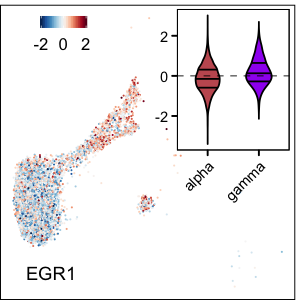

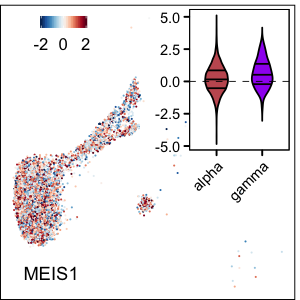

In [71]:
plotMotif_ag <- function(m = "TCF7L2") {
    options(repr.plot.width = 2.5, repr.plot.height = 2.5)
    
    p <- fun.plot.project.motif(motif = m, bks = c(-2, 0, 2), size = 0.25, cls = rev(brewer.pal(n = 11, 
        "RdBu")))
    p$data <- p$data %>% filter(cell_type_overall %in% c("alpha", "gamma"))
    p$data %>% select(UMAP1, UMAP2) %>% apply(2, range) %>% print
    
    p2 <- plotViolin(m, c("alpha", "gamma"))
    
    print(p + annotate(geom = "text", x = -9, y = -4.5, label = m) + annotation_custom((p2 + 
        theme(title = element_blank(), panel.background = element_rect(fill = "white"))) %>% 
        ggplotGrob, -2, 9.5, -2, 7))
    
    ggsave(paste0("~/Dropbox (UCSD_Epigenomics)/workReports/2019-10_islet_rev/Fig1.rev.candid/Fig.1.", 
        m, ".a_g.umap.pdf"), width = 2.5, height = 2.5, units = "in", useDingbats = F)
}
plotMotif_ag("MAFG")
plotMotif_ag("EGR1")
plotMotif_ag("MEIS1")